# Benchmark of Mackey-Glass using ESN

This is an example of ESN where I will try to approximate a Mackey-Glass equation using Echo State Networks.

Installed required modules in Azure. Note that Oger install file must be uploaded to AZURE manually before running these commands.

(For some reason as of 24.08.2017 Azure no longer accepts the "!pip install Oger-1.2.tar.gz". This is probably due to some update.)

If NOT running in Azure ignore this step!

In [1]:
!pip install mdp
!pip install Oger-1.2.tar.gz

    100% |################################| 368kB 1.9MB/s ta 0:00:01
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Processing ./Oger-1.1.2_azure_BETA.tar.gz
  Running setup.py bdist_wheel for Oger ... - \ done
  Stored in directory: /home/nbuser/.cache/pip/wheels/e7/4c/ab/1e62b0065991eb8e45fa5e228659261e8d7b5826f27054e4a6
Successfully built Oger
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#%matplotlib nbagg
%matplotlib inline

import Oger
import mdp
import numpy as np
from matplotlib import pyplot as plt

/home/tilemachos/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/tilemachos/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/tilemachos/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  

# Example run based on the method from http://minds.jacobs-university.de/mantas/code


Class ReservoirNode is already inspectable.
Class SparseReservoirNode is already inspectable.
MSE = 0.013336730567


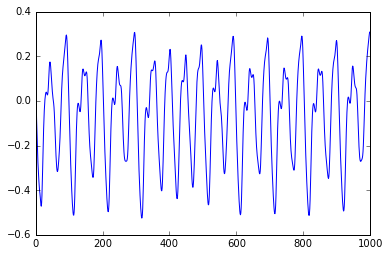

In [6]:
# load the data
trainLen = 2000
testLen = 2000

initLen = 100

data = np.loadtxt('MackeyGlass_t17.txt')

# plot some of it
plt.figure(10).clear()
plt.plot(data[0:1000])

# generate the ESN reservoir
inSize = outSize = 1
resSize = 100
#a = 0.3


#np.random.seed(142)
reservoir = Oger.nodes.ReservoirNode(output_dim=resSize, \
    input_scaling=0.5, bias_scaling=0.0, spectral_radius=0.9, reset_states=False)

# Tell the reservoir to save its states for later plotting 
Oger.utils.make_inspectable(Oger.nodes.ReservoirNode)
Oger.utils.make_inspectable(Oger.nodes.SparseReservoirNode)

# create the output   
reg = 1e-8   
#readout = Oger.nodes.RidgeRegressionNode( reg )
readout = Oger.nodes.RidgeRegressionNode(reg, verbose=True, plot_errors=True )

# enable washout
Oger.utils.enable_washout(Oger.nodes.RidgeRegressionNode, 200)

# connect them into ESN
flow = Oger.nodes.FreerunFlow([reservoir, readout], freerun_steps=testLen)

# train
flow.train([[], [[data[0:trainLen+1,None]]]])

# save states for plotting
X = reservoir.inspect()[0]



# run in a generative mode
Y = flow.execute(np.array(data[trainLen-initLen:trainLen+testLen+1,None]))
# discard the first elements (just a numbering convention)
Y = Y[initLen+1:] 

# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - Y[0:errorLen,0] ) ) / errorLen

print 'MSE = ' + str( mse )

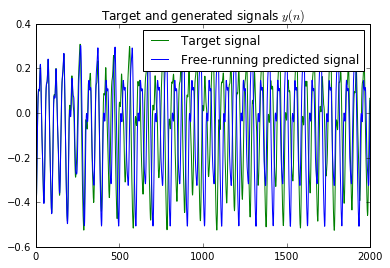

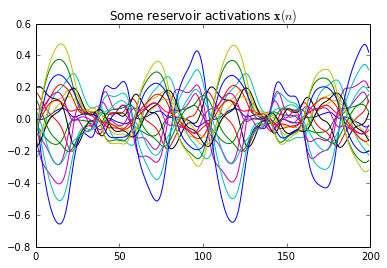

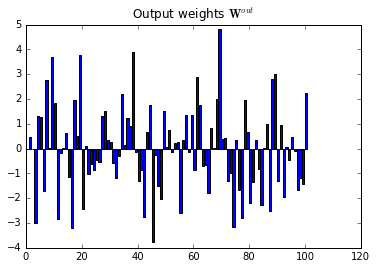

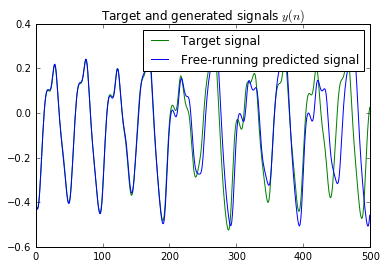

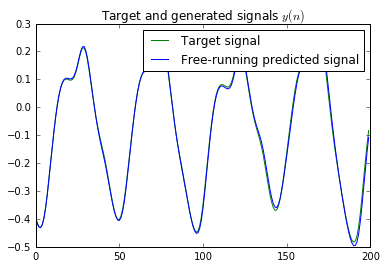

In [7]:
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y , 'b')
plt.legend(['Target signal', 'Free-running predicted signal'])
plt.title('Target and generated signals $y(n)$')

plt.figure(2).clear()
plt.plot( X[initLen:initLen+200,0:20] )
plt.title('Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
#plt.bar( range(1+resSize), readout.beta[:,0] )
plt.bar( range(1+resSize), np.hstack((readout.b, readout.w[:,0])) )
plt.title('Output weights $\mathbf{W}^{out}$')

plt.figure(4).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1][:500], 'g' )
plt.plot( Y[:500] , 'b')
plt.legend(['Target signal', 'Free-running predicted signal'])
plt.title('Target and generated signals $y(n)$')

plt.figure(5).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1][:200], 'g' )
plt.plot( Y[:200] , 'b')
plt.legend(['Target signal', 'Free-running predicted signal'])
plt.title('Target and generated signals $y(n)$')

plt.show()

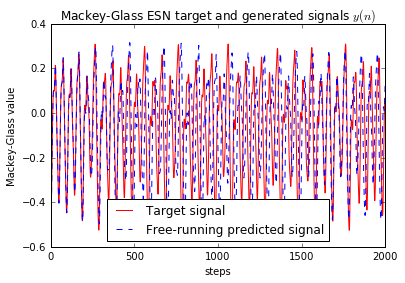

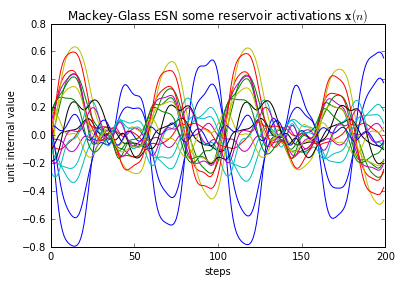

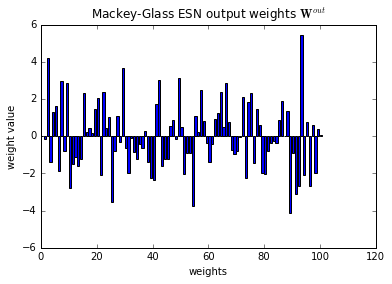

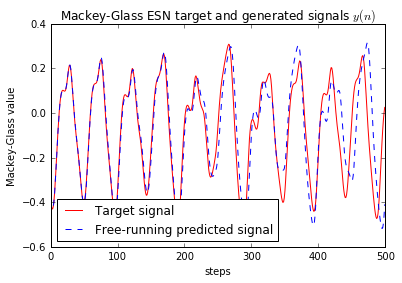

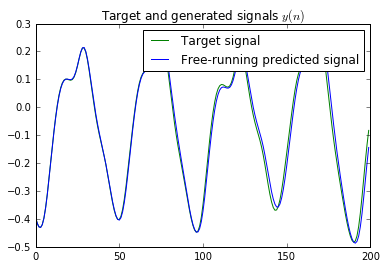

In [19]:
# save some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'r', ls='-' )
plt.plot( Y , 'b', ls='--')
plt.legend(['Target signal', 'Free-running predicted signal'], loc='best')
plt.title('Mackey-Glass ESN target and generated signals $y(n)$')
plt.xlabel('steps')
plt.ylabel('Mackey-Glass value')
plt.savefig('mg_prediction_2000.png')

plt.figure(2).clear()
plt.plot( X[initLen:initLen+200,0:20] )
plt.title('Mackey-Glass ESN some reservoir activations $\mathbf{x}(n)$')
plt.xlabel('steps')
plt.ylabel('unit internal value')
plt.savefig('mg_activations.png')

plt.figure(3).clear()
#plt.bar( range(1+resSize), readout.beta[:,0] )
plt.bar( range(1+resSize), np.hstack((readout.b, readout.w[:,0])) )
plt.title('Mackey-Glass ESN output weights $\mathbf{W}^{out}$')
plt.xlabel('weights')
plt.ylabel('weight value')
plt.savefig('mg_weights.png')

plt.figure(4).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1][:500], 'r' , ls='-' )
plt.plot( Y[:500] , 'b', ls='--' )
plt.legend(['Target signal', 'Free-running predicted signal'], loc='best')
plt.title('Mackey-Glass ESN target and generated signals $y(n)$')
plt.xlabel('steps')
plt.ylabel('Mackey-Glass value')
plt.savefig('mg_prediction_500.png')

plt.figure(5).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1][:200], 'g' )
plt.plot( Y[:200] , 'b')
plt.legend(['Target signal', 'Free-running predicted signal'])
plt.title('Target and generated signals $y(n)$')

plt.show()

In [11]:
test_signals = data[trainLen+1:trainLen+testLen+1][:, np.newaxis]
print "====== 500 steps error ======"
print "NMSE: " + str(Oger.utils.nmse(test_signals[:500], Y[:500]))
print "MSE: " + str(Oger.utils.mse(test_signals[:500], Y[:500]))

print "====== 200 steps error ======"
print "NMSE: " + str(Oger.utils.nmse(test_signals[:200], Y[:200]))
print "MSE: " + str(Oger.utils.mse(test_signals[:200], Y[:200]))

====== 500 steps error ======
NMSE: 0.273066196756
MSE: 0.013336730567
====== 200 steps error ======
NMSE: 0.0019750888109
MSE: 9.91196617311e-05


# Initialize multiple reservoirs to be used

In [2]:
string_names_dict_short = {
    0: 'ESN',
    1: 'DLR',
    2: 'DLRB',
    3: 'SCR',
    4: 'CRJ',
    5: 'FF-ESN',
    6: 'SORM',
    7: 'CyclicSORM'
}

string_names_dict_full = {
    0: 'original ESN',
    1: 'DelayLineReservoir',
    2: 'DelayLineReservoirWithFeedback',
    3: 'SimpleCycleReservoir',
    4: 'CycleReservoirWithJumps',
    5: 'FeedForwardESN',
    6: 'SparseAndOrthogonalMatrices',
    7: 'CyclicSparseAndOrthogonalMatrices'
}

nodes_dict = {
    0: Oger.nodes.ReservoirNode,
    1: Oger.nodes.DelayLineReservoirNode,
    2: Oger.nodes.DelayLineWithFeedbackReservoirNode,
    3: Oger.nodes.SimpleCycleReservoirNode,
    4: Oger.nodes.CycleReservoirWithJumpsNode,
    5: Oger.nodes.FeedForwardESNReservoir,
    6: Oger.nodes.SparseAndOrthogonalMatricesReservoir,
    7: Oger.nodes.CyclicSORMsReservoir
}

# Run the benchmark for the models

In [4]:
washable = True # washout of 200 steps gives better performance
input_scaling = 0.5 # best parameter for most models found through grid-search
bias_scaling = 0.0 # best parameter for most models found through grid-search
number_of_neurons_list = [100, 200, 300, 400, 500] # for the evaluation
number_of_runs = 10 # number of random runs per model

trainLen = 2000
testLen = 2000
initLen = 100
data = np.loadtxt('MackeyGlass_t17.txt')
inSize = outSize = 1
reg = 1e-8  

jump_size = 9

In [12]:
# define the test signals
test_signals = data[trainLen+1:trainLen+testLen+1][:, np.newaxis]

# enable washout
if washable:
    Oger.utils.enable_washout(Oger.nodes.RidgeRegressionNode, 200)

# error lists for 500 steps
mg_nmse_500 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])
mg_mse_500 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])
# error lists for 200 steps
mg_nmse_200 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])
mg_mse_200 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])

# run the test for every reservoir
for i, reservoir_size in mdp.utils.progressinfo(enumerate(number_of_neurons_list), style='timer', length=len(number_of_neurons_list)):
    for key, reservoir_node in nodes_dict.iteritems():
        for j in range(number_of_runs):
            # construct individual nodes
            if key == 4:
                reservoir = reservoir_node(input_dim=inSize, output_dim=reservoir_size, input_scaling=input_scaling, \
                                           bias_scaling=bias_scaling, jump_size=jump_size, reset_states=False)
            else:
                reservoir = reservoir_node(input_dim=inSize, output_dim=reservoir_size, input_scaling=input_scaling, \
                                           bias_scaling=bias_scaling, reset_states=False)

            readout = Oger.nodes.RidgeRegressionNode(reg, verbose=True, plot_errors=True )
            
            # connect them into ESN
            flow = Oger.nodes.FreerunFlow([reservoir, readout], freerun_steps=testLen)

            # train
            flow.train([[], [[data[0:trainLen+1,None]]]])
            
            # run in a generative mode
            Y = flow.execute(np.array(data[trainLen-initLen:trainLen+testLen+1,None]))
            # discard the first elements (just a numbering convention)
            Y = Y[initLen+1:]

            mg_nmse_500[i, key, j] = Oger.utils.nmse(test_signals[:500], Y[:500])
            mg_mse_500[i, key, j] = Oger.utils.mse(test_signals[:500], Y[:500])
            
            mg_nmse_200[i, key, j] = Oger.utils.nmse(test_signals[:200], Y[:200])
            mg_mse_200[i, key, j] = Oger.utils.mse(test_signals[:200], Y[:200])
            
# save the errors for later processing
np.save("mg_nmse_500", mg_nmse_500)
np.save("mg_mse_500", mg_mse_500)
np.save("mg_nmse_200", mg_nmse_200)
np.save("mg_mse_200", mg_mse_200)

100% [0:07:07] - [0:00:00]


# RUN the previous but set a maximum error for most of models

In [9]:
# define the test signals
test_signals = data[trainLen+1:trainLen+testLen+1][:, np.newaxis]

# enable washout
if washable:
    Oger.utils.enable_washout(Oger.nodes.RidgeRegressionNode, 200)

# error lists for 500 steps
mg_nmse_500 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])
mg_mse_500 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])
# error lists for 200 steps
mg_nmse_200 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])
mg_mse_200 = np.zeros([len(number_of_neurons_list), len(nodes_dict), number_of_runs])

count = 0
max_count = mg_nmse_500.shape[0] * mg_nmse_500.shape[1] * mg_nmse_500.shape[2]

# run the test for every reservoir
for i, reservoir_size in mdp.utils.progressinfo(enumerate(number_of_neurons_list), style='timer', length=len(number_of_neurons_list)):
    for key, reservoir_node in nodes_dict.iteritems():
        for j in range(number_of_runs):
            # construct individual nodes
            if key == 4:
                reservoir = reservoir_node(input_dim=inSize, output_dim=reservoir_size, input_scaling=input_scaling, \
                                           bias_scaling=bias_scaling, jump_size=jump_size, reset_states=False)
            else:
                reservoir = reservoir_node(input_dim=inSize, output_dim=reservoir_size, input_scaling=input_scaling, \
                                           bias_scaling=bias_scaling, reset_states=False)
            
            if key == 4 or key == 2:
                readout = Oger.nodes.RidgeRegressionNode(reg, verbose=True, plot_errors=True )

                # connect them into ESN
                flow = Oger.nodes.FreerunFlow([reservoir, readout], freerun_steps=testLen)

                # train
                flow.train([[], [[data[0:trainLen+1,None]]]])

                # run in a generative mode
                Y = flow.execute(np.array(data[trainLen-initLen:trainLen+testLen+1,None]))
                # discard the first elements (just a numbering convention)
                Y = Y[initLen+1:]

                mg_nmse_500[i, key, j] = Oger.utils.nmse(test_signals[:500], Y[:500])
                mg_mse_500[i, key, j] = Oger.utils.mse(test_signals[:500], Y[:500])

                mg_nmse_200[i, key, j] = Oger.utils.nmse(test_signals[:200], Y[:200])
                mg_mse_200[i, key, j] = Oger.utils.mse(test_signals[:200], Y[:200])
                
            else:
                max_error = 10.0
                
                while max_error > 1.0:
                    reservoir = reservoir_node(input_dim=inSize, output_dim=reservoir_size, input_scaling=input_scaling, \
                                           bias_scaling=bias_scaling, reset_states=False)
                    readout = Oger.nodes.RidgeRegressionNode(reg, verbose=True, plot_errors=True )

                    # connect them into ESN
                    flow = Oger.nodes.FreerunFlow([reservoir, readout], freerun_steps=testLen)

                    # train
                    flow.train([[], [[data[0:trainLen+1,None]]]])

                    # run in a generative mode
                    Y = flow.execute(np.array(data[trainLen-initLen:trainLen+testLen+1,None]))
                    # discard the first elements (just a numbering convention)
                    Y = Y[initLen+1:]

                    mg_nmse_500[i, key, j] = Oger.utils.nmse(test_signals[:500], Y[:500])
                    mg_mse_500[i, key, j] = Oger.utils.mse(test_signals[:500], Y[:500])

                    mg_nmse_200[i, key, j] = Oger.utils.nmse(test_signals[:200], Y[:200])
                    mg_mse_200[i, key, j] = Oger.utils.mse(test_signals[:200], Y[:200])
                    
                    max_error = Oger.utils.nmse(test_signals[:500], Y[:500])
                    #print max_error
                    
            count += 1
            print "Progress: ", str(float(count) / max_count)
            
# save the errors for later processing
np.save("mg_nmse_500_limit", mg_nmse_500)
np.save("mg_mse_500_limit", mg_mse_500)
np.save("mg_nmse_200_limit", mg_nmse_200)
np.save("mg_mse_200_limit", mg_mse_200)

  0% ? - ?Progress:  0.0025
Progress:  0.005
Progress:  0.0075
Progress:  0.01
Progress:  0.0125
Progress:  0.015
Progress:  0.0175
Progress:  0.02
Progress:  0.0225
Progress:  0.025
Progress:  0.0275
Progress:  0.03
Progress:  0.0325
Progress:  0.035
Progress:  0.0375
Progress:  0.04
Progress:  0.0425
Progress:  0.045
Progress:  0.0475
Progress:  0.05
Progress:  0.0525
Progress:  0.055
Progress:  0.0575
Progress:  0.06
Progress:  0.0625
Progress:  0.065
Progress:  0.0675
Progress:  0.07
Progress:  0.0725
Progress:  0.075
Progress:  0.0775
Progress:  0.08
Progress:  0.0825
Progress:  0.085
Progress:  0.0875
Progress:  0.09
Progress:  0.0925
Progress:  0.095
Progress:  0.0975
Progress:  0.1
Progress:  0.1025
Progress:  0.105
Progress:  0.1075
Progress:  0.11
Progress:  0.1125
Progress:  0.115
Progress:  0.1175
Progress:  0.12
Progress:  0.1225
Progress:  0.125
Progress:  0.1275
Progress:  0.13
Progress:  0.1325
Progress:  0.135
Progress:  0.1375
Progress:  0.14
Progress:  0.1425
Progres